In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

DATA_PATH = "../data/songs.csv"

In [6]:
df = pd.read_csv(DATA_PATH)
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


We first select the numeric **audio feature columns** that we want to use for
clustering:

- `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`,
  `instrumentalness`, `liveness`, `valence`, `tempo`.

These features describe how each track *sounds* and are suitable for grouping
songs by mood and sonic characteristics.

- We have **32,833 tracks** available for clustering.
- Each track is represented by a **9-dimensional feature vector** made from the
  selected audio features.

So the clustering algorithm will operate on a 32,833 × 9 matrix, where each row
is a song and each column is one of the chosen sound/mood features.

In [7]:
feature_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

df_features = df[feature_cols].dropna().copy()
df_features.shape

(32833, 9)

Before clustering, we standardize the audio features using
`StandardScaler` from scikit-learn.

Different features are on different scales (e.g., `tempo` is in BPM,
`loudness` is in dB, while features like `danceability` and `energy`
are between 0 and 1). If we ran k-means directly on the raw values,
features with larger numeric ranges would dominate the distance
calculations.

`StandardScaler` transforms each feature to have:

- **mean ≈ 0**
- **standard deviation ≈ 1**

so that all 9 features contribute more equally to the clustering.
We call `fit_transform` on `df_features` to both fit the scaler and
apply the transformation, producing `X_scaled`, the standardized
feature matrix.


This scaled matrix `X_scaled` is what we
will pass into k-means for clustering.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

X_scaled.shape  

(32833, 9)

We don't know beforehand how many clusters (k) we should use, so we try
several options and compare them.

Here we loop over `k = 3, 4, 5, 6`:

1. For each `k`, we fit a **KMeans** model on the standardized features
   `X_scaled`.
2. We get the cluster assignments `labels` for all tracks.
3. We compute the **silhouette score**, which measures how well-separated
   the clusters are (higher is better).
4. We store the pair `(k, silhouette)` in a results list and convert it
   to a small DataFrame for easy viewing.

The silhouette score roughly ranges from **-1 to 1**:

- values near **1** → very well-separated clusters,
- values near **0** → clusters are overlapping,
- negative values → many points may be in the wrong cluster.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

k_values = [3, 4, 5, 6]
results = []

for k in k_values:
    print(f"Running k-means for k={k} on dataset...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    results.append({"k": k, "silhouette": sil})

results_df = pd.DataFrame(results)
results_df

Running k-means for k=3 on dataset...
Running k-means for k=4 on dataset...
Running k-means for k=5 on dataset...
Running k-means for k=6 on dataset...


,k,silhouette
0,3,0.140163
1,4,0.151856
2,5,0.155333
3,6,0.157906


The scores are all positive but not very large, which is expected
for real-world music data where moods and genres naturally overlap.
There is a gradual improvement as we increase k, and the highest
score in this range is at **k = 6**.

Based on this, we choose **k = 6 clusters** as a reasonable trade-off:

- it gives slightly better separation than 3–5 clusters,
- and still keeps the number of clusters small enough to interpret and
  map to human-understandable moods.

Based on the silhouette scores, we fix the number of clusters to
**k = 6** and fit a final KMeans model on the full standardized
feature matrix `X_scaled`.

In [10]:
best_k = 6  
kmeans_full = KMeans(n_clusters=best_k, random_state=42)
full_labels = kmeans_full.fit_predict(X_scaled)

df_clustered = df_features.copy()
df_clustered["cluster_id"] = full_labels

df_clustered["cluster_id"].value_counts().sort_index()


cluster_id
0     8914
1    11151
2      720
3     2363
4     5178
5     4507
Name: count, dtype: int64

The clusters are **not all the same size**, which is normal for real
data:

- Cluster 1 is the largest, followed by cluster 0.
- Cluster 2 is much smaller (only 720 tracks), which suggests it
  represents a more specific or niche type of sound/mood.
- The remaining clusters (3, 4, 5) are mid-sized.

This tells us that some “mood groups” (like whatever cluster 1 and 0
represent) are very common in the dataset, while others (like cluster 2)
are rarer. In later steps, we’ll look at the mean feature values and
genres for each `cluster_id` to understand what kind of music each
cluster corresponds to.

To understand what each cluster represents, we compute the mean value of
each audio feature within each cluster.

In [11]:
cluster_summary = (
    df_clustered.groupby("cluster_id")[feature_cols]
    .mean()
    .round(3)
)
cluster_summary

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster_id,,,,,,,,,
0,0.543,0.805,-5.230,0.074,0.064,0.024,0.247,0.387,131.994
1,0.738,0.733,-6.092,0.075,0.136,0.015,0.156,0.679,114.540
2,0.623,0.357,-13.533,0.095,0.615,0.744,0.154,0.383,108.850
3,0.660,0.815,-6.456,0.072,0.049,0.733,0.194,0.385,126.236
4,0.612,0.459,-9.748,0.071,0.447,0.018,0.158,0.400,113.256
5,0.723,0.670,-6.789,0.313,0.177,0.008,0.205,0.550,122.465


We can read each row as the "typical" song in that cluster:

- **Cluster 0 – Intense / serious high-energy tracks**  
  - High energy (0.81), quite loud (−5.2 dB), fairly fast (~132 BPM).  
  - Low acousticness/instrumentalness → produced, vocal tracks.  
  - Valence below 0.4 → more serious or darker mood than happy.  
  → Sounds like intense rock/EDM tracks that are energetic but not very joyful.

- **Cluster 1 – Happy, dancey pop**  
  - Very high danceability (0.74) and high energy (0.73).  
  - Medium tempo (~115 BPM), moderate acousticness, low instrumentalness.  
  - High valence (0.68) → clearly positive / feel-good.  
  → Upbeat, catchy dance-pop style songs suitable for “happy / party” moods.

- **Cluster 2 – Calm acoustic / instrumental**  
  - Lower energy (0.36), much quieter (−13.5 dB), slower tempo (~109 BPM).  
  - Very high acousticness (0.62) and very high instrumentalness (0.74).  
  - Low-to-medium valence (0.38).  
  → Relaxed acoustic or instrumental pieces, more mellow and possibly a bit sad.

- **Cluster 3 – Energetic electronic / techno-like**  
  - High danceability (0.66) and very high energy (0.81).  
  - Very low acousticness (0.05), very high instrumentalness (0.73).  
  - Tempo around 126 BPM, low valence (~0.39).  
  → Driving, intense electronic/techno tracks that are mostly instrumental and
    darker in mood.

- **Cluster 4 – Mid-energy acoustic songs**  
  - Medium energy (0.46) and loudness (−9.7 dB), tempo ~113 BPM.  
  - Fairly high acousticness (0.45) but low instrumentalness (0.02) → acoustic
    songs with vocals.  
  - Valence around 0.40 → slightly on the moody side.  
  → Singer-songwriter / acoustic pop/rock that is neither very calm nor very
    intense.

- **Cluster 5 – Danceable, energetic tracks with lots of speech**  
  - High danceability (0.72) and energy (0.67), tempo ~122 BPM.  
  - Very high speechiness (0.31) compared to other clusters, low
    instrumentalness.  
  - Valence above 0.55 → somewhat positive.  
  → Rap/hip-hop or talky pop tracks that are rhythmic, energetic and more
    upbeat.

Overall, the clusters correspond to distinct mood/sound groups such as
intense high-energy music, happy dance-pop, calm acoustic/ instrumental, dark
electronic, mid-energy acoustic songs, and speech-heavy rap/hip-hop. 

In [12]:
plot_sample = df_clustered.sample(n=5000, random_state=42)
plot_sample_features = plot_sample[feature_cols]
plot_sample_scaled = scaler.transform(plot_sample_features)

To visualize the clusters, we:

1. Take a random sample of **3,000 tracks** from `df_clustered` so the plot
   doesn't become too dense.
2. Use the same `StandardScaler` to transform their 9 audio features.
3. Apply **PCA (Principal Component Analysis)** with `n_components=2` to reduce
   the 9-dimensional feature vectors down to 2 dimensions (`pc1`, `pc2`).
4. Plot the tracks in this 2D PCA space with a scatter plot, colouring points
   by their `cluster_id`.

PCA finds the directions of highest variance in the data. The resulting axes
(`pc1` and `pc2`) don’t have a direct physical meaning like "energy" or
"valence", but they provide a compact 2D view where we can visually inspect how
the clusters are arranged and how much they overlap.

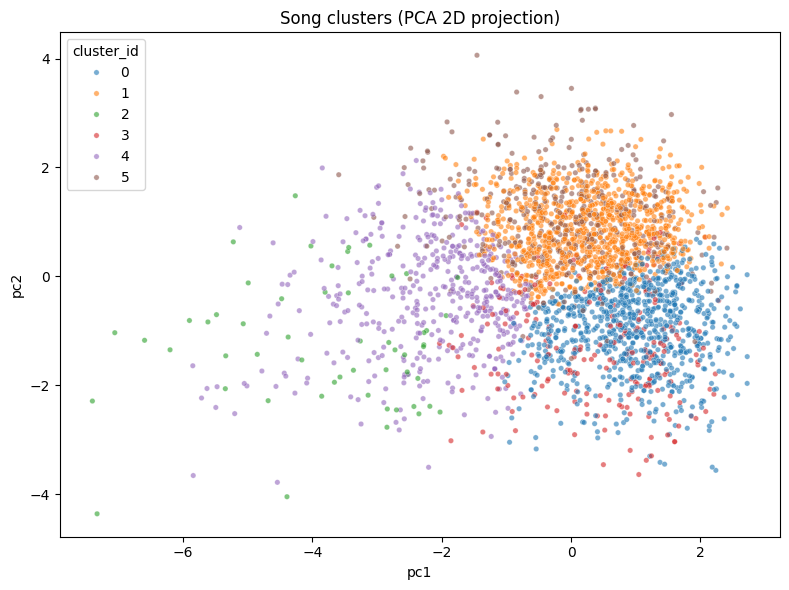

In [13]:
from sklearn.decomposition import PCA

plot_sample = df_clustered.sample(n=3000, random_state=42)

X_plot = scaler.transform(plot_sample[feature_cols])

pca = PCA(n_components=2, random_state=42)
X_plot_2d = pca.fit_transform(X_plot)

pca_df = pd.DataFrame(X_plot_2d, columns=["pc1", "pc2"])
pca_df["cluster_id"] = plot_sample["cluster_id"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="pc1",
    y="pc2",
    hue="cluster_id",
    palette="tab10",
    s=15,
    alpha=0.6,
)
plt.title("Song clusters (PCA 2D projection)")
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.legend(title="cluster_id")
plt.tight_layout()
plt.show()


In the PCA projection:

- Each point is a song, and the colour shows which cluster it belongs to.
- We can see that some clusters occupy different regions of the space:
  - One cluster forms a dense cloud on the right,
  - another cluster sits more toward the upper-right,
  - others spread more toward the left or lower parts of the plot.

There is some overlap between clusters, which is expected:

- We are compressing 9 audio features into just 2 dimensions, so some
  separation is lost in the projection.
- Music moods are inherently fuzzy (a track can be partly "happy" and partly
  "energetic" or "chill"), so we do not expect perfectly separated blobs.

Overall, the PCA plot confirms that the model has found several distinct
regions in feature space (different sonic/mood groups), while also showing that
there are smooth transitions and overlaps between them.


Here we visualize the clusters directly in **valence–energy space**, which is
a common 2D representation of musical mood:

- `valence` (x-axis) measures how positive / happy a track sounds (0–1).
- `energy` (y-axis) measures how intense / loud a track is (0–1).

We:

1. Take a random sample of 3,000 tracks from `df_clustered`.
2. Plot each track as a point with coordinates (`valence`, `energy`).
3. Color points by `cluster_id` to see where each cluster sits in this
   mood space.

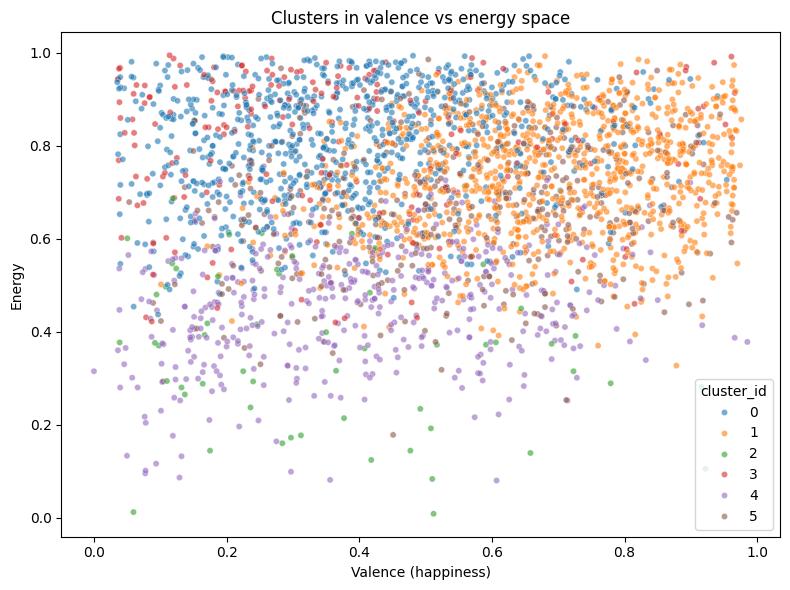

In [14]:
plot_sample = df_clustered.sample(n=3000, random_state=42)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_sample,
    x="valence",
    y="energy",
    hue="cluster_id",
    palette="tab10",
    s=20,
    alpha=0.6,
)
plt.title("Clusters in valence vs energy space")
plt.xlabel("Valence (happiness)")
plt.ylabel("Energy")
plt.legend(title="cluster_id")
plt.tight_layout()
plt.show()


- The **x-axis** goes from sad/negative (left) to happy/positive (right).
- The **y-axis** goes from calm/low-energy (bottom) to intense/high-energy (top).

We can see that:

- Some clusters mainly occupy the **upper band** (high energy), but cover
  different ranges of valence (e.g., more serious vs more happy).
- Other clusters appear more in the **mid-to-lower energy** region, representing
  calmer or more relaxed music.
- There is overlap between clusters, which is expected because:
  - valence and energy capture only part of the full 9D feature space,
  - and real music moods are not strictly separated (songs can be “medium
    energy and somewhat happy”, etc.).

Overall, this plot shows that our clusters cover different regions of the
valence–energy mood space (calm vs energetic, sad vs happy). 

### Clustering evaluation – silhouette score

We evaluate k-means for several values of k using the silhouette score,
which measures how well-separated the clusters are (higher is better).

The plot shows that:

- All silhouette scores are positive, which means the clustering is
  better than random grouping.
- The score increases gradually and reaches its best value around 
  **k = 6** in our tested range.

Based on this, we use **6 clusters** as a reasonable trade-off between
cluster quality and interpretability.


In [15]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.evaluation import compute_silhouette_for_ks

ks = [3, 4, 5, 6, 7, 8]
sil_df = compute_silhouette_for_ks(X_scaled, ks)
sil_df

,k,silhouette
0,3,0.140163
1,4,0.151856
2,5,0.155333
3,6,0.157906
4,7,0.151860
5,8,0.135511


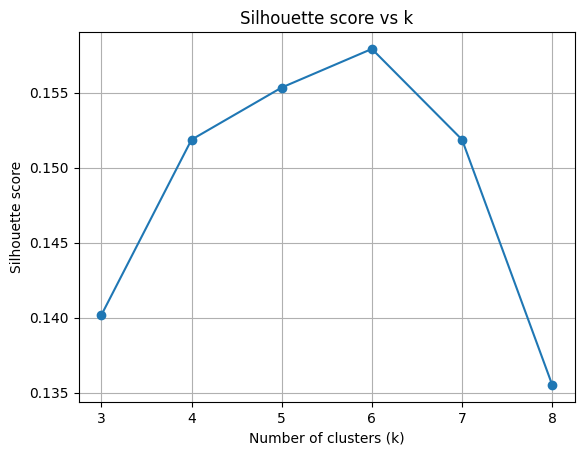

In [16]:
import matplotlib.pyplot as plt

plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k")
plt.grid(True)
plt.show()


### Cluster size distribution

We also look at how many songs fall into each cluster.

The distribution is not uniform:

- some clusters contain many songs (e.g., cluster 1 and 0),
- while others are much smaller (e.g., cluster 2).

This is expected for real-world music data: some moods/sound types are
more common than others. Smaller clusters often correspond to more
specialized or niche sounds.


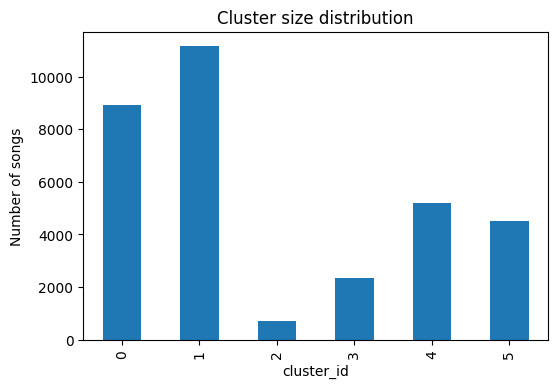

In [18]:
from src.utils.evaluation import cluster_size_distribution
cluster_sizes = cluster_size_distribution(df_clustered["cluster_id"].values)
cluster_sizes
cluster_sizes.plot(kind="bar", figsize=(6, 4))
plt.xlabel("cluster_id")
plt.ylabel("Number of songs")
plt.title("Cluster size distribution")
plt.show()
